In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [130]:
dataframe = pd.read_csv('kbo_21_24_merged.csv', encoding='cp949')
df = dataframe.copy()

# 파생변수
df['나이'] = df['연도'] - df['출생연도']
df['플레이오프'] = df['팀순위'].apply(lambda x: 1 if x <= 5 else 0)
df.head(3)

,연도,순위,선수명,팀명,AVG,G,PA,AB,R,H,...,팀패수,팀무승부수,팀승률,팀게임차,포지션,투구유형,타격유형,출생연도,나이,플레이오프
0,2021,1,이정후,키움,0.360,123,544,464,78,167,...,67,7,0.511,7.0,외야수,우투,좌타,1998,23,1
1,2021,2,전준우,롯데,0.348,144,619,552,88,192,...,71,8,0.478,11.5,외야수,우투,우타,1986,35,0
2,2021,3,강백호,KT,0.347,142,627,516,76,179,...,59,9,0.563,0.0,내야수,우투,좌타,1999,22,1


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연도      213 non-null    int64  
 1   순위      213 non-null    int64  
 2   선수명     213 non-null    object 
 3   팀명      213 non-null    object 
 4   AVG     213 non-null    float64
 5   G       213 non-null    int64  
 6   PA      213 non-null    int64  
 7   AB      213 non-null    int64  
 8   R       213 non-null    int64  
 9   H       213 non-null    int64  
 10  2B      213 non-null    int64  
 11  3B      213 non-null    int64  
 12  HR      213 non-null    int64  
 13  TB      213 non-null    int64  
 14  RBI     213 non-null    int64  
 15  SAC     213 non-null    int64  
 16  SF      213 non-null    int64  
 17  BB      213 non-null    int64  
 18  IBB     213 non-null    int64  
 19  HBP     213 non-null    int64  
 20  SO      213 non-null    int64  
 21  GDP     213 non-null    int64  
 22  SL

In [132]:
df.isna().sum() # 결측치 없음

연도        0
순위        0
선수명       0
팀명        0
AVG       0
G         0
PA        0
AB        0
R         0
H         0
2B        0
3B        0
HR        0
TB        0
RBI       0
SAC       0
SF        0
BB        0
IBB       0
HBP       0
SO        0
GDP       0
SLG       0
OBP       0
OPS       0
MH        0
RISP      0
PH-BA     0
XBH       0
GO        0
AO        0
GO/AO     0
GW RBI    0
BB/K      0
P/PA      0
ISOP      0
XR        0
GPA       0
팀순위       0
경기수       0
팀승수       0
팀패수       0
팀무승부수     0
팀승률       0
팀게임차      0
포지션       0
투구유형      0
타격유형      0
출생연도      0
나이        0
플레이오프     0
dtype: int64

In [133]:
df.columns

Index(['연도', '순위', '선수명', '팀명', 'AVG', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'TB', 'RBI', 'SAC', 'SF', 'BB', 'IBB', 'HBP', 'SO', 'GDP', 'SLG',
       'OBP', 'OPS', 'MH', 'RISP', 'PH-BA', 'XBH', 'GO', 'AO', 'GO/AO',
       'GW RBI', 'BB/K', 'P/PA', 'ISOP', 'XR', 'GPA', '팀순위', '경기수', '팀승수',
       '팀패수', '팀무승부수', '팀승률', '팀게임차', '포지션', '투구유형', '타격유형', '출생연도', '나이',
       '플레이오프'],
      dtype='object')

### 모델링: 멀티태스크 모델
1. 다중 클래스 분류: 1~10위 순위 예측  
2. 이진 분류: 플레이오프 진출 여부 예측(T/F)

#### 1. 타겟 변수 생성

In [134]:
# 멀티태스크용 타겟
df['rank_target'] = df['팀순위'].astype('category')            # 다중 클래스
df['playoff_target'] = df['플레이오프'].astype('category')     # 이진 클래스

In [135]:
df[['rank_target','playoff_target']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   rank_target     213 non-null    category
 1   playoff_target  213 non-null    category
dtypes: category(2)
memory usage: 1.0 KB


#### 2. 변수 선택

In [136]:
# 포함되면 안되는 정보:
leakage_cols = [
    '팀순위', '순위', '선수명', '팀명',
    '팀승수', '팀패수', '팀무승부수', '팀승률', '팀게임차', '출생연도',
    'rank_target', 'playoff_target', '플레이오프'
]

# 시간 구분용: 학습 피처에서는 제외
meta_cols = ['연도']  

# 학습에 활용할 변수 생성
drop_cols = leakage_cols + meta_cols
feature_cols = [col for col in df.columns if col not in drop_cols]

#### 3. train/test split

In [137]:
train_df = df[df['연도'].isin([2021, 2022, 2023])]
test_df = df[df['연도'] == 2024].copy()

print(test_df.연도.unique())

[2024]


#### 4. X, y 분리

In [138]:
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train_rank = train_df['rank_target']
y_test_rank = test_df['rank_target']

y_train_playoff = train_df['playoff_target']
y_test_playoff = test_df['playoff_target']

#### 5. 범주형 변수 전처리

In [139]:
# 범주형 변수 자동 탐지
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# One-hot 인코딩 적용: 트리 기반 모델링을 진행하기에 drop_first는 생략
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)

# train/test 컬럼 일치시키기
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [140]:
y_train_playoff.value_counts() # 불균형이라 볼 수 없음.

playoff_target
1    90
0    67
Name: count, dtype: int64

#### 6. 모델 학습 및 예측

In [141]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

##### 1) Random Forest

In [142]:
# (1) 순위 예측 (다중 클래스)
rf_rank = RandomForestClassifier(random_state=42)
rf_rank.fit(X_train, y_train_rank)
rf_rank_preds = rf_rank.predict(X_test)

# (2) 플레이오프 예측 (이진 분류)
# rf_playoff = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_playoff = RandomForestClassifier(random_state=42)
rf_playoff.fit(X_train, y_train_playoff)
rf_playoff_preds = rf_playoff.predict(X_test)

##### 2) XGBoost

In [143]:
# softmax는 0부터 시작해야함
y_train_rank_xgb = y_train_rank.astype(int) - 1
y_test_rank_xgb = y_test_rank.astype(int) - 1

In [144]:
# (1) 순위 예측 (다중 클래스)
xgb_rank = XGBClassifier(objective='multi:softmax', num_class=10, eval_metric='mlogloss', random_state=42)
xgb_rank.fit(X_train, y_train_rank_xgb)
xgb_rank_preds = xgb_rank.predict(X_test)
xgb_rank_preds += 1 # 예측 결과 복원 (0~9 => 1~10)


# (2) 플레이오프 예측 (이진 분류)
# imbalance_ratio = (y_train_playoff == 0).sum() / (y_train_playoff == 1).sum() # 불균형 비율
# xgb_playoff = XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=imbalance_ratio, random_state=42)
xgb_playoff = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb_playoff.fit(X_train, y_train_playoff)
xgb_playoff_preds = xgb_playoff.predict(X_test)

##### 3) lightGBM

In [145]:
# (1) 순위 예측 (다중 클래스)
lgbm_rank = LGBMClassifier(objective='multiclass', num_class=10, metric='multi_logloss', random_state=42)
lgbm_rank.fit(X_train, y_train_rank)
lgbm_rank_preds = lgbm_rank.predict(X_test)

# (2) 플레이오프 예측 (이진 분류)
# lgbm_playoff = LGBMClassifier(objective='binary', metric='binary_logloss', class_weight='balanced', random_state=42)
lgbm_playoff = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
lgbm_playoff.fit(X_train, y_train_playoff)
lgbm_playoff_preds = lgbm_playoff.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 157, number of used features: 39
[LightGBM] [Info] Start training from score -2.111807
[LightGBM] [Info] Start training from score -2.060514
[LightGBM] [Info] Start training from score -2.283657
[LightGBM] [Info] Start training from score -2.348196
[LightGBM] [Info] Start training from score -2.060514
[LightGBM] [Info] Start training from score -2.283657
[LightGBM] [Info] Start training from score -2.859021
[LightGBM] [Info] Start training from score -2.223032
[LightGBM] [Info] Start training from score -2.348196
[LightGBM] [Info] Start training from score -2.753661
[LightGBM] [Warning] No furth

#### 7. 기본 모델 평가

In [146]:
def evaluate_model(name, y_true, y_pred, average_type='macro'):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average_type)
    print(f"{name:<25} | Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")
    return [name, acc, f1]


In [147]:
results = []
results.append(evaluate_model("RF - 팀순위", y_test_rank, rf_rank_preds))
results.append(evaluate_model("XGB - 팀순위", y_test_rank, xgb_rank_preds))
results.append(evaluate_model("LGBM - 팀순위", y_test_rank, lgbm_rank_preds))
results.append(evaluate_model("RF - 플레이오프", y_test_playoff, rf_playoff_preds))
results.append(evaluate_model("XGB - 플레이오프", y_test_playoff, xgb_playoff_preds))
results.append(evaluate_model("LGBM - 플레이오프", y_test_playoff, lgbm_playoff_preds))

results_df = pd.DataFrame(results, columns=["모델", "Accuracy", "F1"])
results_df

RF - 팀순위                  | Accuracy: 0.0893 | F1 Score: 0.0647
XGB - 팀순위                 | Accuracy: 0.0893 | F1 Score: 0.0811
LGBM - 팀순위                | Accuracy: 0.0893 | F1 Score: 0.0861
RF - 플레이오프                | Accuracy: 0.5179 | F1 Score: 0.4806
XGB - 플레이오프               | Accuracy: 0.4821 | F1 Score: 0.4684
LGBM - 플레이오프              | Accuracy: 0.4286 | F1 Score: 0.4219


,모델,Accuracy,F1
0,RF - 팀순위,0.089286,0.064747
1,XGB - 팀순위,0.089286,0.081111
2,LGBM - 팀순위,0.089286,0.086053
3,RF - 플레이오프,0.517857,0.480591
4,XGB - 플레이오프,0.482143,0.468412
5,LGBM - 플레이오프,0.428571,0.421935


#### 8. 모델 디벨롭

In [148]:
from sklearn.model_selection import GridSearchCV

##### 1) Random Forest

In [149]:
# 파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_clf = RandomForestClassifier(random_state=42)
# rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_rf = GridSearchCV(rf_clf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)

# 이진 분류용 플레이오프 타겟에 대해 튜닝
grid_rf.fit(X_train, y_train_playoff)

print("Best Parameters:", grid_rf.best_params_)
print("Best F1 Score:", grid_rf.best_score_.round(4))


Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\wjdtj\anaconda3\envs\jsy\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 Score: 0.673


##### 2) XGBoost

In [150]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
# xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=imbalance_ratio, use_label_encoder=False, random_state=42)
grid_xgb = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train_playoff)

print("XGB Best Params:", grid_xgb.best_params_)
print("XGB Best F1:", grid_xgb.best_score_.round(4))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
XGB Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
XGB Best F1: 0.7101


c:\Users\wjdtj\anaconda3\envs\jsy\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:31:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##### 3) LightGBM

In [151]:
# 하이퍼파라미터 후보군 설정
param_grid_lgbm = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [10, 20, 30]
}

# 모델 정의
lgbm_clf = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
# lgbm_clf = LGBMClassifier(objective='binary', metric='binary_logloss', class_weight='balanced', random_state=42)

# GridSearchCV 실행
grid_lgbm = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid_lgbm, scoring='f1', cv=3, verbose=1, n_jobs=-1)

# 학습
grid_lgbm.fit(X_train, y_train_playoff)

# 결과 출력
print("Best Parameters:", grid_lgbm.best_params_)
print("Best F1 Score:", grid_lgbm.best_score_.round(4))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 90, number of negative: 67
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1222
[LightGBM] [Info] Number of data points in the train set: 157, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573248 -> initscore=0.295117
[LightGBM] [Info] Start training from score 0.295117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

#### 9. 최종 모델 선정 및 성능 평가

In [152]:
# 1. 최적 모델들 꺼내오기
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_lgbm = grid_lgbm.best_estimator_

# 2. 각 모델별 예측 수행
rf_final_preds = best_rf.predict(X_test)
xgb_final_preds = best_xgb.predict(X_test)
lgbm_final_preds = best_lgbm.predict(X_test)

# 3. 평가 함수 정의
def print_metrics(name, y_true, y_pred):
    print(f"\n모델명: [{name}]")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("F1 Score:", round(f1_score(y_true, y_pred), 4))
    print("Classification Report:\n", classification_report(y_true, y_pred))

# 4. 모델별 평가 결과 출력
print_metrics("Random Forest", y_test_playoff, rf_final_preds)
print_metrics("XGBoost", y_test_playoff, xgb_final_preds)
print_metrics("LightGBM", y_test_playoff, lgbm_final_preds)


모델명: [Random Forest]
Accuracy: 0.4286
F1 Score: 0.5556
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.15      0.20        26
           1       0.48      0.67      0.56        30

    accuracy                           0.43        56
   macro avg       0.38      0.41      0.38        56
weighted avg       0.39      0.43      0.39        56


모델명: [XGBoost]
Accuracy: 0.6071
F1 Score: 0.7105
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.27      0.39        26
           1       0.59      0.90      0.71        30

    accuracy                           0.61        56
   macro avg       0.64      0.58      0.55        56
weighted avg       0.64      0.61      0.56        56


모델명: [LightGBM]
Accuracy: 0.5357
F1 Score: 0.6486
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.23      0.32        26
        

In [ ]:
print(y_test_playoff.to_list())
print(xgb_playoff_preds.tolist())

[0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]


=> 데이터 불균형 문제도 90:69로 거의 존재하지 않는다 판단하였음.  

**[모델 성능]**  
Accuracy가 낮으나, XGBoost에서 가장 뛰어난 성능을 보였으며,  
플레이오프에 진출하는 팀에 대해 가장 잘 맞추었음.  

#### 10. Explaning Model: 변수의 영향력 설명
- Feature Importance: 변수 중요도, 모델의 성능에 영향을 미친 정도
- SHAP: Y 값을 예측하는데 변수가 작용한 힘을 제시 

In [154]:
from xgboost import plot_importance
import shap

##### 1) Feature Importance

##### 2) SHAP

In [155]:
# SHAP 값 계산
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

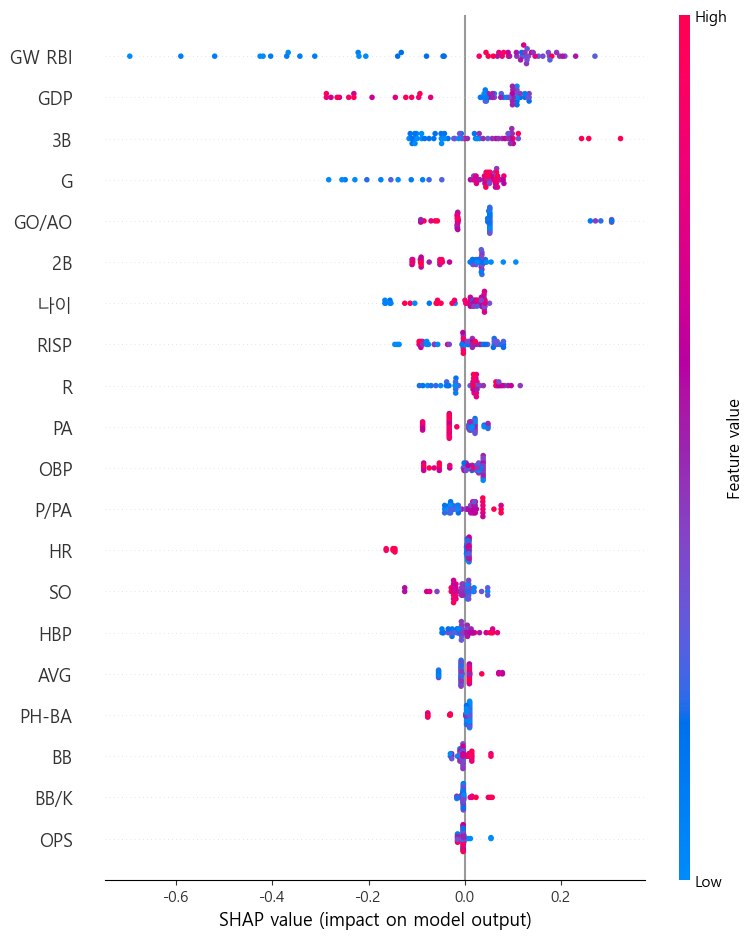

In [156]:
shap.summary_plot(shap_values, X_test)

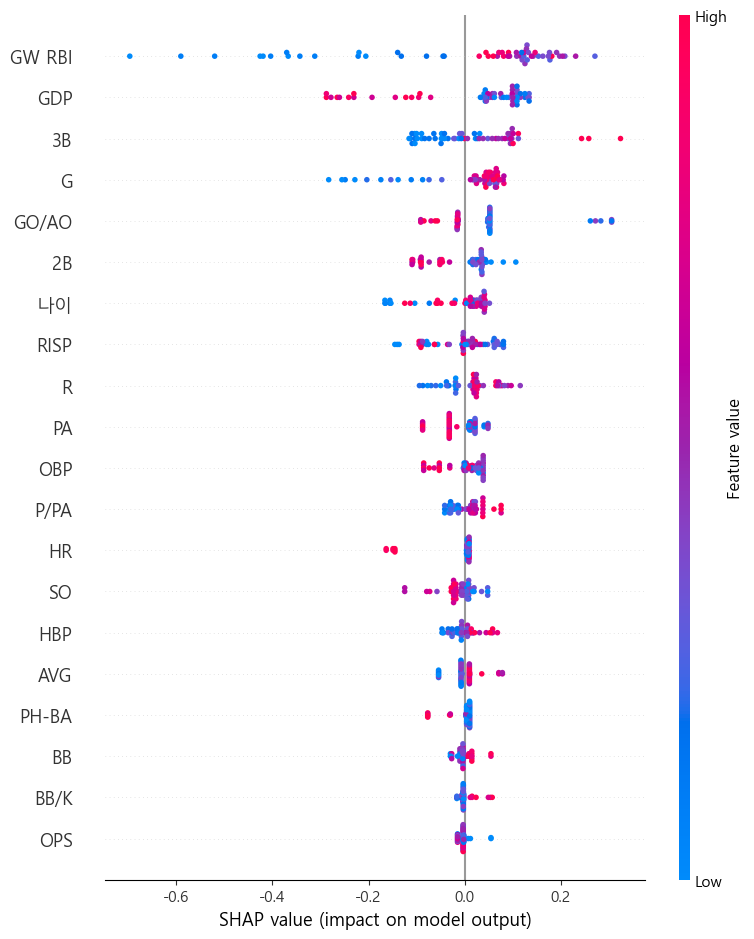

In [157]:
shap.summary_plot(shap_values, X_test)